<a href="https://colab.research.google.com/github/Debayan2004/Multi-Modal-Brain-Tumor-Classification-and-Segmentation-and-Survivability-prediction/blob/main/Brain_Tumor_Segmentation_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("debayan20000/brain-tumor-segmentation")

print("Path to dataset files:", path)

100%|██████████| 4.16G/4.16G [00:47<00:00, 94.9MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/debayan20000/brain-tumor-segmentation/versions/1


In [2]:
mv /root/.cache/kagglehub/datasets/debayan20000/brain-tumor-segmentation/versions/1 /content/

In [3]:
import nibabel as nib
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Function to load NIfTI images
def load_nifti(file_path):
    img = nib.load(file_path)
    img_data = img.get_fdata()  # Convert to numpy array
    img_data = img_data / np.max(img_data)  # Normalize
    return torch.tensor(img_data, dtype=torch.float32)  # Convert to PyTorch tensor

# Define paths
brats_train_path = "/content/1/MICCAI_BraTS2020_TrainingData"
brats_val_path = "/content/1/MICCAI_BraTS2020_ValidationData"

# Get all patient folders
train_patients = sorted(os.listdir(brats_train_path))
val_patients = sorted(os.listdir(brats_val_path))

# Split validation set into validation and test (80-20 split)
val_patients, test_patients = train_test_split(val_patients, test_size=0.2, random_state=42)

print(f"Train Patients: {len(train_patients)}")
print(f"Validation Patients: {len(val_patients)}")
print(f"Test Patients: {len(test_patients)}")



Train Patients: 371
Validation Patients: 101
Test Patients: 26


In [4]:
class BrainTumorSegmentationDataset(Dataset):
    def __init__(self, patient_list, data_dir, is_train=True):
        self.patient_list = patient_list
        self.data_dir = data_dir
        self.is_train = is_train  # True for training, False for validation/test

    def __len__(self):
        return len(self.patient_list)

    def __getitem__(self, idx):
        patient_id = self.patient_list[idx]
        patient_path = os.path.join(self.data_dir, patient_id)

        # Load MRI sequences dynamically based on folder name
        flair = load_nifti(os.path.join(patient_path, f"{patient_id}_flair.nii"))
        t1ce = load_nifti(os.path.join(patient_path, f"{patient_id}_t1ce.nii"))
        t2 = load_nifti(os.path.join(patient_path, f"{patient_id}_t2.nii"))
        t1 = load_nifti(os.path.join(patient_path, f"{patient_id}_t1.nii"))

        # Stack MRI sequences into 4-channel input
        image = torch.stack([flair, t1ce, t2, t1])

        # Load segmentation mask (ONLY for training)
        mask = None
        if self.is_train:
            seg_path = os.path.join(patient_path, f"{patient_id}_seg.nii")
            if os.path.exists(seg_path):
                mask = load_nifti(seg_path)
            else:
                mask = torch.zeros_like(flair)  # Placeholder mask (optional)

        return image, mask

# Define paths
brats_train_path = "/content/1/MICCAI_BraTS2020_TrainingData"
brats_val_path = "/content/1/MICCAI_BraTS2020_ValidationData"

# Get patient subfolders
train_patients = sorted(os.listdir(brats_train_path))
val_patients = sorted(os.listdir(brats_val_path))

# Split validation set into validation & test (80-20 split)
val_patients, test_patients = train_test_split(val_patients, test_size=0.2, random_state=42)

# Create datasets
train_dataset = BrainTumorSegmentationDataset(train_patients, brats_train_path, is_train=True)
val_dataset = BrainTumorSegmentationDataset(val_patients, brats_val_path, is_train=False)
test_dataset = BrainTumorSegmentationDataset(test_patients, brats_val_path, is_train=False)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print("Data preparation complete!")

Data preparation complete!


Training Dataset Sample:
Image Shape: torch.Size([4, 240, 240, 155])
Mask Shape: torch.Size([240, 240, 155])


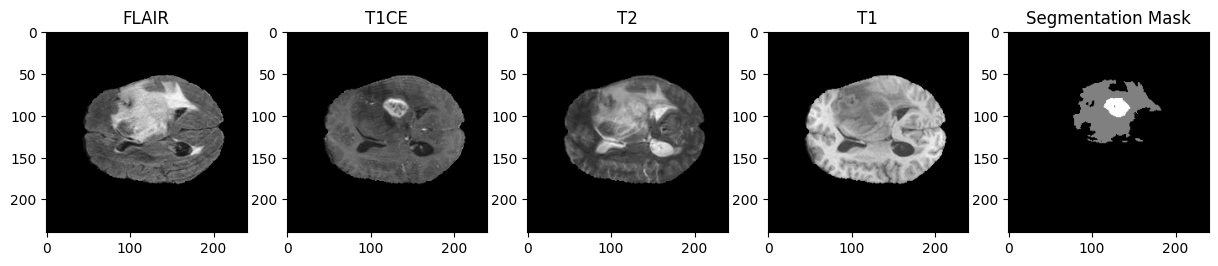


Validation Dataset Sample:
Image Shape: torch.Size([4, 240, 240, 155])


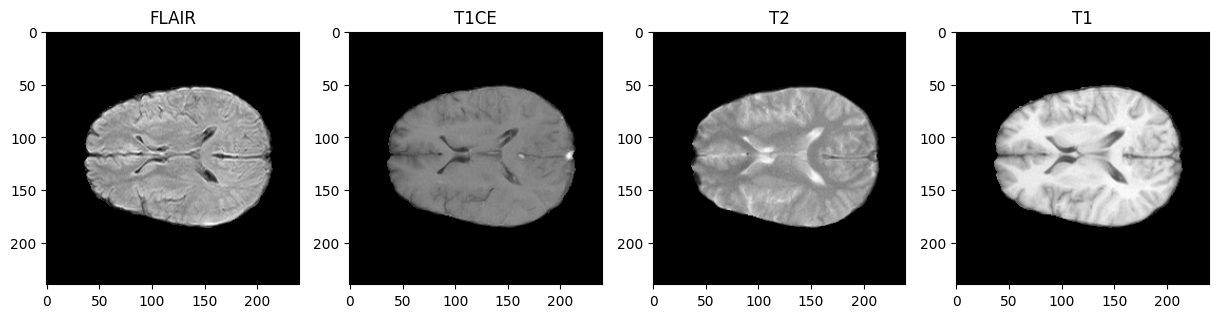


Test Dataset Sample:
Image Shape: torch.Size([4, 240, 240, 155])


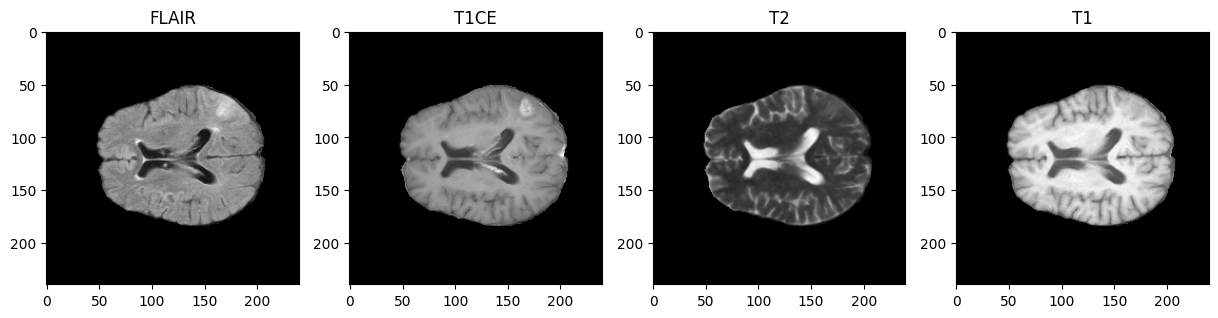

In [5]:
import matplotlib.pyplot as plt

# Function to visualize a dataset sample
def visualize_sample(dataset, index=0, is_train=True):
    image, mask = dataset[index]  # Load sample
    print(f"Image Shape: {image.shape}")  # Expected: (4, H, W, D) (4 channels: Flair, T1ce, T2, T1)
    if is_train:
        print(f"Mask Shape: {mask.shape}")  # Expected: (H, W, D)

    # Convert to NumPy for visualization
    image_np = image.numpy()
    if is_train:
        mask_np = mask.numpy()

    # Select a middle slice for visualization
    middle_slice = image_np.shape[-1] // 2

    fig, axes = plt.subplots(1, 5 if is_train else 4, figsize=(15, 5))

    # Plot each MRI sequence
    axes[0].imshow(image_np[0, :, :, middle_slice], cmap="gray")
    axes[0].set_title("FLAIR")

    axes[1].imshow(image_np[1, :, :, middle_slice], cmap="gray")
    axes[1].set_title("T1CE")

    axes[2].imshow(image_np[2, :, :, middle_slice], cmap="gray")
    axes[2].set_title("T2")

    axes[3].imshow(image_np[3, :, :, middle_slice], cmap="gray")
    axes[3].set_title("T1")

    # If training, show the mask
    if is_train:
        axes[4].imshow(mask_np[:, :, middle_slice], cmap="gray")
        axes[4].set_title("Segmentation Mask")

    plt.show()

# Check training dataset (with mask)
print("Training Dataset Sample:")
visualize_sample(train_dataset, index=0, is_train=True)

# Check validation dataset (without mask)
print("\nValidation Dataset Sample:")
visualize_sample(val_dataset, index=0, is_train=False)

# Check test dataset (without mask)
print("\nTest Dataset Sample:")
visualize_sample(test_dataset, index=0, is_train=False)
